# Computational Statistical Physics: Final Assessment

## Instructions

1. Solve each of the problems in this notebook.
2. Document any piece of code that is written to solve the problems.
3. Explain the reasoning behind each solution in Markdown cells.
4. **After solving all exercises, execute the whole notebook and save it as HTML**.
5. Send both, the notebook .ipynb file and the HTML file to: leopoldo.carbajal@correo.nucleares.unam.mx by **11:59 PM (Mexico City Time) January 17th, 2021**.

No assessments will be marked if received after the deadline: **11:59 PM (Mexico City Time) January 17th, 2021**.

## Reading material

1. M.E.J. Newman & G.T. Barkema, *Monte Carlo Methods in Statistical Physics, Clarendon Press*, Oxford Press.
2. D.P. Landau & K. Binder, *A guide to monte carlo simulations in statistical physics*, Cambridge Press.
3. Course slides.

## Introduction

This notebook contains **three exercises** that will be used to assess the course.

All problems are about MC simulations of the 2-D Ising model, that can be generalized to model more complex problems in phyiscs and beyond.

### Ising Model Definition

We define the Ising model as before, as an array of spins with up (+1) and down states (-1) on a rectangular grid of arbitrary size. 

The Hamiltonian for the 2-D Ising model is given by:

$$H = -J\sum_{\langle i,j \rangle}s_is_j - h\sum_{i=1}^{N}s_i\ ,$$

where $s_i$ are the spins on the rectangular grid, $J$ is the interaction strenght between spins and $h$ is an external field acting upon the spins.

We will consider that only nearest neighbors can interact, that is, only up, down, left and right interactions are allowed.

This time, we are allowing the spin system to have arbitrary size, that is, the system comprises a total of $N_{spins} = N_X\times N_Y$, where $N_X$ and $N_Y$ are the number of spins along the $x$-axis and $y$-axis, respectively.

Exact solutions in the thermodynamic limit have been found for $h=0$. **See Onsager's 1944 paper in Google Drive (Onsager1944) for details**.

In [1]:
from numpy import*
import matplotlib.pyplot as plt
%matplotlib inline
import os
import copy
from tqdm.notebook import tqdm

## 2-D Ising Model Parameters

The model parameters to be set are:

1. Total number of spins, $N_{spins} = N_X\times N_Y$.
2. Interaction strength, $J$.
3. External field, $h$. **In this notebook we will consider only $h=0$**.
4. Temperature, $kT$.

The inverse of temperature $\beta=1/kT$, is automatically defined when set $kT$.

In [2]:
# Number of spins in 2-D periodic lattice
NX = 10
NY = 10
Nspins = NX*NY

# Interaction strenght
J = 1.0

# External field
h = 0.0

---

## Baseline Algorithm: Metropolis Algorithm

We implement the Metropolis (-Hastings) MC algorithm. This algorithm implements the following methods:

- Importance sampling.
- Single spin flip -- This restricts the step in energy space, keeping ergodicity.
- Optimal acceptance probability $P(\mu \rightarrow \nu) = g(\mu \rightarrow \nu)A(\mu \rightarrow \nu)$.


$$\frac{P(\mu \rightarrow \nu)}{P(\nu \rightarrow \mu)} = \frac{g(\mu \rightarrow \nu)A(\mu \rightarrow \nu)}{g(\nu \rightarrow \mu)A(\nu \rightarrow \mu)} = \frac{A(\mu \rightarrow \nu)}{A(\nu \rightarrow \mu)} = e^{-\beta(E_\nu - E_\mu)}$$

The acceptance probabilities can be chosen arbitrary, always that these fulfill the detailed balance condition (above).

In particular, $A$ can take the form

- Initial energy: $E_\mu$
- Final energy: $E_\nu$
- Difference in energy: $\Delta E = E_\nu - E_\mu$

$$A(\mu \rightarrow \nu) = \begin{cases} 
                           e^{-\beta(E_\nu - E_\mu)} = e^{-\beta\Delta E}, & E_\nu - E_\mu > 0\\
                           1, & \mbox{Otherwise}
                           \end{cases}
   $$
   
Recipe:

1. Randomly chose a spin to flip from the initial configuration.
2. Flip it, call this new configuration the test move.
3. Compute initial and test energy.
4. Compute change in energy.
5. Compute $A(\mu \rightarrow \nu)$.
6. Repeat.

## Metropolis Algorithm Implementation

First, the function below generates a system with $N$ spins in a random way. See documentation in function for details. 

<span style="color:blue">**NOTE: All functions implemented for solving a problem should be documented as the function below.**</span>

In [3]:
def generate_spins(N, dim=1, seed=0):
    """
    Function to generate a random array of spins.
    
    Parameters
    ----------
    N : Integer or tuple containing the size of the 1-D or 2-D array of spins.
    dim : Dimensionality of the array of spins. This must be consistent with N.
    seed : Seed of pseudo-random number generator to be used. Use this paramter
           whenever reproducibility is needed.
    
    Returns
    -------
    spins : 1-D or 2-D array of spins.
    
    Example
    -------
    For generating a 5x5 2-D array of spins we use this function as follows:
    
    generate_spins(N=(5,5), dim=2, seed=0)
    
    this gives the following array
    
    array([[ 1., -1., -1., -1.,  1.],
           [ 1.,  1.,  1.,  1.,  1.],
           [ 1., -1.,  1., -1.,  1.],
           [-1.,  1.,  1., -1., -1.],
           [-1., -1.,  1.,  1.,  1.]])
    """
    
    # Pseudo-random number generator
   # generator = Generator( PCG64(seed) )

    # Initial condition for spins
    if (dim == 1):
        if isinstance(N,int):
            spins = random.uniform(low=0.0, high=1.0, size=N)
        else:
            raise ValueError('N should be an integer for dim=1')
    else:
        if ( isinstance(N,tuple) & (len(N)==2) & all([isinstance(n,int) for n in N]) ):
            spins = random.uniform(low=0.0, high=1.0, size=N)
        else:
            raise ValueError('N should be a tuple of two integers for dim=2, N=(NX,NY)')

    # Spins up or down
    bool_mask = spins < 0.5

    spins[~bool_mask] = 1.0 # up
    spins[bool_mask]  = -1.0  # down
    
    return spins

## Visualization as a tool

We use some visualization as a tool for qualitative analysis. The function below plots the spin system, white and black means spins with values $s_i=-1$ and $s_i=1$, respectively.

In [4]:
def simple_visualization(spins, grid=False, annotate=False, mask=None, mask_other=None, mask_value='O'):
    """
    Function that generates visualization of a system of spins with various annotations.
    
    Parameters
    ----------
    spins : 2-D numpy array containing spins' orientations.
    grid : Boolean flag to indicate whether separation between spins are plotted (True) or not (False).
    annotate : Boolean flag to indicate whether spins are enumerated (True) or not (False).
    mask : Boolean mask to be used together with mask_value to only annotate those spins with True values in mask.
           mask must have the same shape than spins.
    mask_other : Boolean mask to be used to only annotate those spins with True values in mask.
                 All spins with True values in mask_other are annotated with an `X`. mask_other must have 
                 the same shape than spins.
    mask_value : String value to be used to annotate spins together with mask.
    
    Returns
    -------
    
    
    Example
    -------
    We can generate a visualization of a 5x7 system of spins as follows:
    
    simple_visualization(spins=generate_spins(N=(5,7), dim=2, seed=0), grid=True, annotate=True)
    
    """
    
    if mask is not None:
        assert spins.shape == mask.shape, 'Parameters spins and mask must have the same shape'

    if mask_other is not None:
        assert spins.shape == mask_other.shape, 'Parameters spins and mask must have the same shape'
    
    # Black squares represent spins -1
    # Black squares represent spins +1
    fig, ax = plt.subplots()

    # Generate plot of spins
    im = ax.imshow(spins)
    
    # Ticks
    yticks_position = arange(0,spins.shape[0]) - 0.5
    xticks_position = arange(0,spins.shape[1]) - 0.5
    plt.xticks(ticks=xticks_position)
    plt.yticks(ticks=yticks_position)
    
    plt.tick_params(axis='both',
                    which='both',
                    bottom=False,
                    top=False,
                    left=False,
                    right=False,
                    labelbottom=False,
                    labelleft=False
                   )
    
    if annotate:
        # Loop over data dimensions and create text annotations.
        for ii in range(spins.shape[0]): # rows
            for jj in range(spins.shape[1]): # cols
                spin_number = jj + ii*spins.shape[1] + 1
                text = ax.text(jj, ii, spin_number,
                               ha="center", va="center", color="r")
                
    if (mask is not None):
        # Loop over data dimensions and create text annotations.
        for ii in range(spins.shape[0]): # rows
            for jj in range(spins.shape[1]): # cols
                if mask[ii,jj]:
                    text = ax.text(jj, ii, mask_value,
                                   ha="center", va="center", color="r")
    
    if (mask_other is not None):
        # Loop over data dimensions and create text annotations.
        for ii in range(spins.shape[0]): # rows
            for jj in range(spins.shape[1]): # cols
                if mask_other[ii,jj]:
                    text = ax.text(jj, ii, 'X',
                                   ha="center", va="center", color="r")
                    
    
    if grid:
        plt.grid(b=True, which='major', axis='both')
    
    plt.xlabel(r'$N_X=$' + str(spins.shape[1]))
    plt.ylabel(r'$N_Y=$' + str(spins.shape[0]))        
    
    # Set colormap to gray
    plt.set_cmap(cmap='gray')

    plt.show()

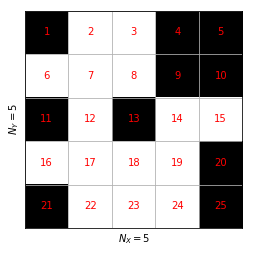

In [7]:
simple_visualization(spins=generate_spins(N=(5,5), dim=2, seed=0), grid=True, annotate=True)

## 2-D Ising model: Hamiltonian for PBC

In the cells below we implement a function that computes the Hamiltonian of the 2-D Ising model with PBC.

<span style="color:red">**NOTE: This version of `H_2DI` contains a bugfix with respect to previous notebooks. Please use this version of the function from now on.**</span>.

In [8]:
def H_2DI(s, J=1.0, h=0.0, PBC=True):
    """
    Hamiltonian of the 1-D Ising model.
    
    Parameters
    ----------
    s : numpy array of spins, up and down.
    J : interaction strength.
    h : external field intensity.
    PBC : boolean flag to determine whether PBC are used (True) or not (False)
    
    Returns
    -------
    H : Hamiltonian of 2-D Ising model
    """

    # PBC = J*s[-1]*s[0]
    if PBC:
        # s[i,j] = s[row i,col j]
        # i == rows
        # j == columns
        
        # Interaction spin-spin term
        
        # slicing, numpy
        # Internal spins - interaction with spins to the right
        H =  ( s[1:-1,1:-1]*s[1:-1,2:] ).sum()
        # Internal spins - interaction with spins to the left
        H += ( s[1:-1,1:-1]*s[1:-1,0:-2] ).sum()
        # Internal spins - interaction with spins above
        H += ( s[1:-1,1:-1]*s[0:-2,1:-1] ).sum()
        # Internal spins - interaction with spins below
        H += ( s[1:-1,1:-1]*s[2:,1:-1] ).sum()
        
        # Right boundary -- Order = Left + Right + Above + Below
        # Interaction with spins to the left
        H += ( s[1:-1,-1]*s[1:-1,-2] ).sum()
        # Interaction with spins to the right (PBC)
        H += ( s[1:-1,-1]*s[1:-1,0] ).sum()
        # Interaction with spins above
        H += ( s[1:-1,-1]*s[0:-2,-1] ).sum()
        # Interaction with spins below
        H += ( s[1:-1,-1]*s[2:,-1] ).sum()
        
        # Left boundary
        H += ( s[1:-1,0]*s[1:-1,-1] + s[1:-1,0]*s[1:-1,1] + s[1:-1,0]*s[0:-2,0] + s[1:-1,0]*s[2:,0] ).sum()
        
        # Top boundary
        H += ( s[0,1:-1]*s[0,0:-2] + s[0,1:-1]*s[0,2:] + s[0,1:-1]*s[-1,1:-1] + s[0,1:-1]*s[1,1:-1] ).sum()
        
        # Bottom boundary
        H += ( s[-1,1:-1]*s[-1,0:-2] + s[-1,1:-1]*s[-1,2:] + s[-1,1:-1]*s[-2,1:-1] + s[-1,1:-1]*s[0,1:-1] ).sum()
        
        # Top-right corner
        H += s[0,-1]*s[0,-2] + s[0,-1]*s[0,0] + s[0,-1]*s[-1,-1] + s[0,-1]*s[1,-1]
        
        # Bottom-right corner
        H += s[-1,-1]*s[-1,-2] + s[-1,-1]*s[-1,0] + s[-1,-1]*s[-2,-1] + s[-1,-1]*s[0,-1]
        
        # Top-left corner
        H += s[0,0]*s[0,-1] + s[0,0]*s[0,1] + s[0,0]*s[-1,0] + s[0,0]*s[1,0]
        
        # Bottom-left corner
        H += s[-1,0]*s[-1,-1] + s[-1,0]*s[-1,1] + s[-1,0]*s[-2,0] + s[-1,0]*s[0,0]
        
        # Bugfix
        H *= -0.5*J
        
        # External field term
        H += -h*s.sum()
        
    else:
        # To implement Non-PBC
        pass
    
    return H

Now, we implement the Metropolis algorithm using the calculation of the Hamiltonian above.

In [9]:
def Metropolis_Move_2D(spins, beta=1.0, J=1.0, h=0.0):
    """
    Function that implements a single step of the Metropolis-Hastings.
    
    Parameters
    ----------
    spins : 2-D array of spins to be used a initial condition.
    beta : Inverse of temperature 1/kT.
    J : Interaction strength.
    h : External field strength.
    
    Returns
    -------
    s_new : New configuration of spins after Metropolis-Hastings step.
    
    Example
    -------
    To perform a step of the Metropolis-Hastings algorithm using a 5x5 initial configuration of spins
    with parameters kT=1.0, J=1.0 and h=0.0 we use this function as follows:
    
    Metropolis_Move_2D(spins=generate_spins(N=(5,5), dim=2, seed=0),
                       beta=1.0,
                       J=1.0,
                       h=1.0
                       )
    
    """
    
    
    # 1. Randomly chose a spin
    ii = random.randint(low=0, 
                           high=spins.shape[0]
                          )
    
    jj = random.randint(low=0, 
                           high=spins.shape[1]
                          )
    
    # 2. Try flip
    s_test = spins.copy() # Getting a copy is important!
    s_test[ii,jj] = -s_test[ii,jj]
    
    # 3. Compute energies
    # Initial energy
    Ei = H_2DI(s=spins, J=J, h=h)
    
    # Final energy due to flip
    Ef = H_2DI(s=s_test, J=J, h=h)
    
    # 4. Compare energies
    DE = Ef - Ei 
    
    # 5. Check condition
    if (DE <= 0.0):
        s_new = s_test.copy()
    else:
        random_number = random.uniform(low=0.0, high=1.0)
            
        Pacc = exp(-beta*DE)

        # Check acceptance probability
        if (random_number <= Pacc):
            s_new = s_test.copy()
        else:
            s_new = spins.copy()
            
    return s_new

The function below performs a Monte Carlo simulation of the 2-D Ising model of a system of spins `spins` for a number of iterations `IT`, with interaction strenght `J`, external field `h`, and inverse temperature ($\beta=1/kT$) `beta`.

In [10]:
def Metropolis_Sim_2D_Ising(spins, J=1.0, h=0.0, beta=1.0, IT=100, plot=True):
    """
    Function that performs a MC simulation of the 1-D Ising system using Metropolis-Hastings algorithm.
    
    Parameters
    ----------
    spins : 2-D array of spins to be used a initial condition.
    beta : Inverse of temperature 1/kT.
    J : Interaction strength.
    h : External field strength.
    IT : Number of steps/iterations of the Metropolis-Hastings algorithm.
    plot : Boolean flag to indicate whether plots of time series are generated (True) or not (False).
    
    Returns
    -------
    spins : Final configuration of spins by the end of the simulation.
    tseries : 2-D numpy array of shape (3,IT) containing simulation time tseries[0,:], energy per spin tseries[1,:]
              and magnetization per spin tseries[2,:].
    """
    
    N = spins.size # Number of spins in simulation
    tseries = zeros(shape=(3,IT), dtype=float)

    # Metropolis MC simulation
    for it in tqdm(range(IT), desc='Monte Carlo Iteration'):
        spins = Metropolis_Move_2D(spins=spins,
                                   beta=beta,
                                   J=J,
                                   h=h
                                  )
        # Optimize
        tseries[1,it] = H_2DI(s=spins, J=J, h=h, PBC=True) # Energy
        tseries[2,it] = abs( spins.sum() ) # Magnetization
        
    E = tseries[1,:]/float(N) # Energy per spin
    M = tseries[2,:]/float(N) # Magnetization per spin
    tseries[0,:] = arange(0,IT, dtype=float)/float(N)
    
    if plot:
        # Quick plot of internal energy vs. time    
        fig, axl = plt.subplots()

        color = 'tab:red'
        axl.set_xlabel(r'Time $t$ [MC steps per site]')
        axl.set_ylabel(r'$\mathcal{E}(t)$ [per site]', color=color)
        axl.plot(tseries[0,:], E, color=color)
        axl.tick_params(axis='y', labelcolor=color)

        axr = axl.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        axr.set_ylabel(r'$\mathcal{M}(t)$ [per site]', color=color)
        axr.plot(tseries[0,:], M, color=color)
        axr.tick_params(axis='y', labelcolor=color)

        #fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()
    
    return spins, tseries

The function below computes the auto-correlation function of the time series returned by a simulation, this can be used to infer the correlation time as seen in previous clases.

In [16]:
def autocorrelationTime(tseries, semilog=False):
    """
    Function to compute auto-correlation time.
    
    Parameters
    ----------
    tseries : tseries object returned by Metropolis_Sim_2D_Ising. See documentation of this function.
    semilog : Boolean flag to indicate whether we use logarithmic scale in y-axis (True) or not (False).
    
    Returns
    -------
    chi : Numpy array with autocorrelation values along dim=1. chi[0,:] has the times, and chi[1:,:] the
          autocorrelatin of each time series in tseries.
    taus : Iterations corresponding to the autocorrelation times of each time series in tseries.
    
    """
    
    # Maximum simulation time and corresponding index
    tmax = tseries[0,-1]
    imax = tseries.shape[1]
    
    chi = zeros_like(tseries, dtype=float)
    for ii in tqdm(range(imax), desc='Time'):
        chi[0,ii] = tseries[0,ii]
        
        # "Time step" in units of iterations
        DT = float(imax - ii)
        
        offset = imax - ii
        chi[1:,ii] = sum(tseries[1:,0:offset]*tseries[1:,-offset:], axis=1)/DT \
                     - tseries[1:,0:offset].sum(axis=1)*tseries[1:,-offset:].sum(axis=1)/DT**2
    
    # We normalize to initial value
    for jj in arange(start=1, stop=tseries.shape[0]):
        chi[jj,:] /= chi[jj,0]
    
    # We find first minimum value of the auto-correlation time for each time series
    imin = abs(chi - 1.0/exp(1)).argmin(axis=1)
    taus = imin[1:]

    for jj in arange(start=1, stop=tseries.shape[0]):
        print("Correlation time for time series: %3d | iteration: %8d" % (jj,imin[jj]))
    
    fig = plt.figure()
    for jj in arange(start=1, stop=tseries.shape[0]):
        yAxis = linspace(start=0.0, stop=1.0, num=10)
        tau = chi[0,imin[jj]]*ones_like(yAxis)
        
        if semilog:
            plot = plt.semilogy(chi[0,:], chi[jj,:], label='Time series: ' + str(jj))
            # Plot correlation time
            plt.semilogy(tau, yAxis, color=plot[-1].get_color(), linestyle='dashed', label='Time series: ' + str(jj) + r' ($\tau$)')
        else:
            plot = plt.plot(chi[0,:], chi[jj,:], label='Time series: ' + str(jj))
            # Plot correlation time
            plt.plot(tau, yAxis, color=plot[-1].get_color(), linestyle='dashed', label='Time series: ' + str(jj) + r' ($\tau$)')
            
    plt.legend()
    plt.xlabel(r'Time $t$ [Iterations]')
    plt.ylabel(r'$\chi(t)/\chi(0)$')
    plt.show()
    
    return chi, taus

## Example: 2-D Ising model with PBC on a 10x10 grid - computation of observables

In the example below, we simulate a 10x10 grid and compute the specific heat per spin $c$. A brief computation of the MC error in our computation of $c$ is performed as well.

In [21]:
10000/49

204.08163265306123

Temperature: 1.90 | Beta: 0.53


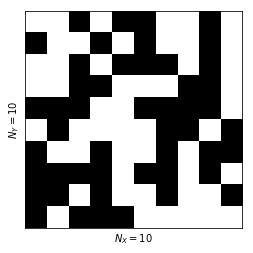

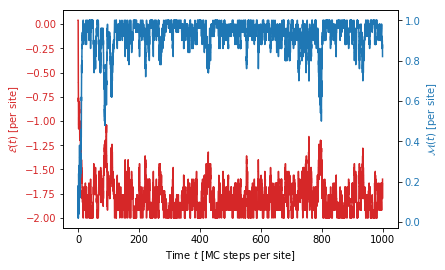

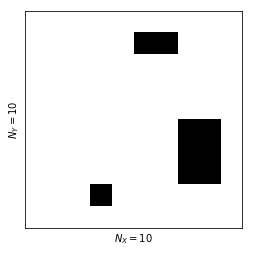

In [88]:
# Other params
J = 1.0
h = 0.0

# Temperature
#kT = 2.4*J
kT = 1.9*J
beta = 1.0/kT

print('Temperature: %2.2f | Beta: %2.2f' % (kT, beta))

# Number of iterations
IT = 100000

foo = generate_spins(N=(10,10), dim=2, seed=2)

simple_visualization(spins=foo, grid=False, annotate=False)

si,tseries = Metropolis_Sim_2D_Ising(spins=foo, 
                                     J=J, 
                                     h=h, 
                                     beta=beta, 
                                     IT=IT
                                    )

simple_visualization(spins=si, grid=False, annotate=False)

We now need to infer the correlation time $\tau$. This is done below.

To accelerate the computation of the auto-correlation, we sub-sample the time series of our MMC simulation

In [89]:
# Number of MC iterations that respresents a MC pass
pass_iterations = si.size

# Number of MC passes
n_passes = int( tseries.shape[1]/pass_iterations )

print("Monte Carlo passes in simulaton: %8d" % n_passes)

# Sub-sampling of original time series
_tseries = zeros(shape=(tseries.shape[0],n_passes), dtype=float)

for ii in tqdm(range(n_passes), desc='Passes'):
    index = ii*pass_iterations
    _tseries[:,ii] = tseries[:,index]

Monte Carlo passes in simulaton:     1000



Correlation time for time series:   1 | iteration:      797
Correlation time for time series:   2 | iteration:        6


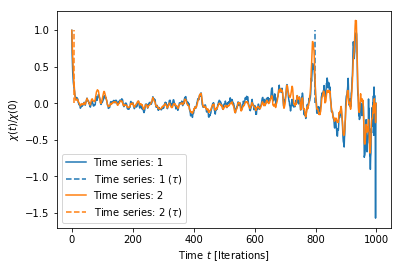

In [90]:
chi,taus = autocorrelationTime(_tseries, semilog=False)

## Obtaining curves of magnetization and specific heat

In the cell below we compute the magnetization and specific heat using the blocking method, see Section 3.4.2 of *M.E.J. Newman & G.T. Barkema, Monte Carlo Methods in Statistical Physics, Clarendon Press, Oxford* for details.

From the cells above, we infer that the auto-correlation time $\tau$ occurs at about $\sim$ 100 MC passes. We use that value as the `offset` in the cell below to get rid of the transient in our time series.

In [95]:
# Other params
J = 1.0
h = 0.0

# Number of iterations
IT = 50000

kT = J*linspace(start=0.5, stop=5.0, num=50)

magnetization = zeros(shape=len(kT), dtype=float)
magnetization_error = zeros(shape=len(kT), dtype=float)
specific_heat = zeros(shape=len(kT), dtype=float)
specific_heat_error = zeros(shape=len(kT), dtype=float)
for jj,kT_ in enumerate(kT):
    beta_ = 1.0/kT_
    
    si,tseries = Metropolis_Sim_2D_Ising(spins=generate_spins(N=(10,10), dim=2, seed=2), 
                                         J=J, 
                                         h=h, 
                                         beta=beta_, 
                                         IT=IT,
                                         plot=False
                                        )

    # Number of MC iterations that respresents a MC pass, same as number of spins in simulation
    pass_iterations = si.size

    # Number of spins in simulation
    N = pass_iterations

    # Offset in units of iterations
    offset =12  #500

    initial_index = offset*pass_iterations

    # Size of each block
    block_size = 12*pass_iterations

    num_blocks = int( float(tseries[:,initial_index:].shape[1])/block_size )

    # Magnetization
    m = zeros(shape=num_blocks, dtype=float)
    # Specific heat
    c = zeros(shape=num_blocks, dtype=float)

    for ii in tqdm(range(num_blocks),desc='Blocks'):
        # We compute the initial and final indices for each block
        index_1 = ii*block_size + initial_index
        index_2 = index_1 + block_size

        # To implement
        m[ii] = (1/N)*sum(tseries[2,index_1:index_2])/block_size #Calcula el promedio de 
                #la magnetización en el bloque
        c[ii] =(beta_**2/N)*(sum(tseries[1,index_1:index_2]**2)/block_size
                -sum(tseries[1,index_1:index_2])**2/(block_size**2))
                #Calcula el calor específico en el bloque

    # To implement
    eme=sum(m)/num_blocks #Promedio del calor específico
    eme2=sum(m**2)/num_blocks #Promedio del cuadrado del calor específico
    ce=sum(c)/num_blocks #Promedio del calor específico
    ce2=sum(c**2)/num_blocks #Promedio del cuadrado del calor específico 
    magnetization[jj]=eme
    specific_heat[jj]=ce
    magnetization_error[jj]=sqrt((eme2-eme**2)/(num_blocks-1)) 
    specific_heat_error[jj]=sqrt((ce2-ce**2)/(num_blocks-1)) 

En la celda anterior se calculan la magnetización y el calor específico empleando el método de bloques. 
Para ello se divide el conjunto de iteraciones dentro de bloques de cierto tamaño, procurando que dicho tamaño sea dos veces el tiempo de correlación para evitar que las mediciones de la magnétización o el calor específico estén correlacionadas entre dos bloques distintos. 
En cada bloque, se obbtiene el promedio de la magnetización por espín y el calor específico empleando la fórmula
$$\begin{equation}
C_v=\frac{\beta^2}{N}(\langle E^2\rangle-\langle E\rangle^2)
\end{equation}$$
Una vez hechas las mediciones anteriores en cada bloque se procede a promediar a lo largo de toda la simulación, empleando las fórmulas para los errores
$$\begin{equation}
\sigma_m=\sqrt{\frac{1}{n_{bloques}-1}(\langle M^2\rangle-\langle M\rangle^2)}
\end{equation}$$

$$\begin{equation}
\sigma_C=\sqrt{\frac{1}{n_{bloques}-1}(\langle C_v^2\rangle-\langle C_v\rangle^2)}
\end{equation}$$

In [96]:
kT = J*linspace(start=0.5, stop=5.0, num=50)

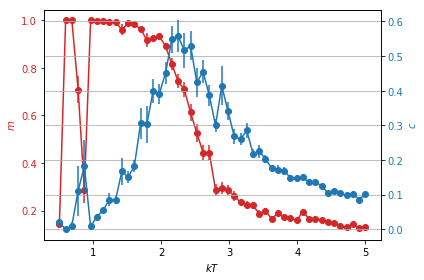

In [97]:
fig, axl = plt.subplots()

color = 'tab:red'
axl.set_xlabel(r'$kT$')
axl.set_ylabel(r'$m$', color=color)
axl.errorbar(kT, magnetization, magnetization_error, color=color, marker='o')
axl.tick_params(axis='y', labelcolor=color)

axr = axl.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
axr.set_ylabel(r'$c$', color=color)
axr.errorbar(kT, specific_heat, specific_heat_error,color=color, marker='o')
axr.tick_params(axis='y', labelcolor=color)

plt.grid(b=True, which='both', axis='both')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

**NOTE:** How the above figure compares with Fig. 3.7 of *M.E.J. Newman & G.T. Barkema, Monte Carlo Methods in Statistical Physics, Clarendon Press, Oxford*?

## <span style="color:red">Exercise 1 (3 points) </span>

In the cells above we computed the magnetization per spin of the 2-D Ising model with PBC. In this exercise you will have to:

1. Compute the magnetization and specific heat per spin for a grid $10\times 10$ spins using Metropolis-Hastings algorithm.
2. Compute the variations in both the magnetization and specific heat using the **blocking method** and plot them as error bars.

**NOTE**: A possible layout for your plots might be as the one shown below.

## Wolff Algorithm

Now we are ready to implement and use the Wolff algorithm. For a detailed discussion and implementation algorithm please refer to Sec. 4.2 of *M.E.J. Newman & G.T. Barkema, Monte Carlo Methods in Statistical Physics, Clarendon Press, Oxford*.

In the cell below we implement the algorithm for finding the cluster that will be flipped in a single step of the Wolff algorithm. Specifically, the function `find_cluster` implements steps 1 to 4 of the slide below.

See lecture of Dec 2, for details.

In [61]:
def find_cluster(spins, beta=1.0, J=1.0, h=0.0):# seed=None, showplots=False):
    """
    Function that computes/finds the cluster to be flipped in a single step in the Wolff algorithm.
    
    Parameters
    ----------
    spins : 2-D array of spins to be used a initial condition.
    beta : Inverse of temperature 1/kT.
    J : Interaction strength.
    h : External field strength.
    seed : Seed to be used in pseudo-random generator. If seed=None, a random seed is used every time the
           function is called.
    showplots : Boolean flag to indicate whether plots of iterations of algorithm to find cluster are shown
                (True) or not (False).
    
    Returns
    spins fliped: El arreglo de espines con el cúmulo seleccionado invertido
    -------
    """
    
    # Implement your function here!
    spins_fliped=zeros_like(spins,dtype=bool)#Malla boleana que contendrá "True" en aquellos sitios---
                                            #---que se añadan al cluster
    Nx=spins.shape[1] #Determina el número de columnas de la malla de espines
    Ny=spins.shape[0] #Determina el núero de renglones de la malla de espines
    ii = random.randint(low=0,high=Ny)    #Determina de forma aleatoria la posición del sitio semilla 
    jj = random.randint(low=0,high=Nx)  
    s_test = spins.copy() # Getting a copy is important!
    indexx=[] #Esta lista contendrá los nuevos sitios que se irán añadiendo al cluster en cada iteración
    indexx.append([ii,jj]) #Primero se añade el sitio semilla
    spins_fliped[ii,jj]=True #También se "activa" el sitio semilla en la malla boleana
    P_add=1-exp(-2*beta*J) #Se calcula el valor de la P_add
    value=s_test[ii,jj] #Se guarda la orientación del sitio semilla en el flotante "value"
    while len(indexx)!=0: #Si la lista de nuevos sitios añadidos está vacía entonces detente el proceso
        indexx_aux=[] #Lista de sitios auxiliar 
        for i in indexx: #Determina los primeros vecinos de los sitios de la lista y añádelos--- 
            #---al cluster según el algoritmo de Wolf
            ii,jj=i[0],i[1]
            ii_up=(ii-1)%Ny #Vecino superior
            ii_down=(ii+1)%Ny #Vecino inferior
            jj_left=(jj-1)%Nx #Vecino izquierdo
            jj_right=(jj+1)%Ny #Vecino derecho
            #Si el vecino superior apunta en la misma dirección que el espín del sitio---
            #---(ii,jj) y si aún no se ha añadido al---
            #--- cluster entonces añadelo con probabilidad P_add 
            if s_test[ii_up,jj]==value and spins_fliped[ii_up,jj]==False: 
                random_number = random.uniform(low=0.0, high=1.0)
                if random_number<=P_add:
                    indexx_aux.append([ii_up,jj])
                    spins_fliped[ii_up,jj]=True #Activa el sitio que se acaba de añadir
            #Si el vecino inferior apunta en la misma dirección que el espín del sitio
            # (ii,jj) y si aún no se ha añadido al
            #cluster entonces añadelo con probabilidad P_add 
            if s_test[ii_down,jj]==value and spins_fliped[ii_down,jj]==False:
                random_number = random.uniform(low=0.0, high=1.0)
                if random_number<=P_add:
                    indexx_aux.append([ii_down,jj])
                    spins_fliped[ii_down,jj]=True
            #Si el vecino izquierdo apunta en la misma dirección que el espín del sitio
            # (ii,jj) y si aún no se ha añadido al
            #cluster entonces añadelo con probabilidad P_add 
            if s_test[ii,jj_left]==value and spins_fliped[ii,jj_left]==False:
                random_number = random.uniform(low=0.0, high=1.0)
                if random_number<=P_add:
                    indexx_aux.append([ii,jj_left])
                    spins_fliped[ii,jj_left]=True
            #Si el vecino derecho apunta en la misma dirección que el espín del sitio
            # (ii,jj) y si aún no se ha añadido al
            #cluster entonces añadelo con probabilidad P_add 
            if s_test[ii,jj_right]==value and spins_fliped[ii,jj_right]==False:
                random_number = random.uniform(low=0.0, high=1.0)
                if random_number<=P_add:
                    indexx_aux.append([ii,jj_right])
                    spins_fliped[ii,jj_right]=True
            indexx=indexx_aux

            
    #return s_new
    
    #cluster = np.zeros_like(spins, dtype=bool)
    cluster=spins_fliped
    return cluster

In [60]:
def find_cluster_visualization(spins, beta=1.0, J=1.0, h=0.0):# seed=None, showplots=False):
    """
    Function that computes/finds the cluster to be flipped in a single step in the Wolff algorithm
    and show a subplot of the process of adding new sites to the cluster
    
    Parameters
    ----------
    spins : 2-D array of spins to be used a initial condition.
    beta : Inverse of temperature 1/kT.
    J : Interaction strength.
    h : External field strength.
    seed : Seed to be used in pseudo-random generator. If seed=None, a random seed is used every time the
           function is called.
    showplots : Boolean flag to indicate whether plots of iterations of algorithm to find cluster are shown
                (True) or not (False).
    
    Returns
    Process visualization: El conjunto de figuras del proceso para añadir nuevos espines a un 
    cúmulo. 
    El código es bastante similar al empleado para la función find_cluster pero se añaden 
    características adicionales para graficar los pasos del proceso de añadir nuevos sitios al cúmulo
    -------
    """
    
    # Implement your function here!
    spins_fliped=zeros_like(spins,dtype=bool)
    Nx=spins.shape[1]
    Ny=spins.shape[0]
    ii = random.randint(low=0,high=Nx)    
    jj = random.randint(low=0,high=Ny)   # 2. Try flip
    s_test = spins.copy()
    s_evol=spins.copy()#Malla actualizada en cada paso
    indexx=[]
    indexx.append([ii,jj])
    spins_fliped[ii,jj]=True
    P_add=1-exp(-2*beta*J)
    EVOL=[] #Lista vacía que contedrá las mallas actualizas en cada paso
    value=s_test[ii,jj]
    s_evol[ii,jj]=0.25*value#Se le asocia un nuevo valor a cada nuevo espín añadido 
                            #para poder identificarlo en el mapa de calor
    EVOL.append(s_evol)
    s_aux=s_evol.copy()#Malla auxiliar que contendrá los nuevos espines añadidos en cada paso
    while len(indexx)!=0:
        indexx_aux=[]
        s_aux=s_aux.copy()
        for i in indexx:
            ii,jj=i[0],i[1]
            s_aux[ii,jj]=0.5*value #Se asocia un valor distinto a los espines que ya habían sido 
                                #previamente añadidos para identificarlos en el mapa de calor
            ii_up=(ii-1)%Ny
            ii_down=(ii+1)%Ny
            jj_left=(jj-1)%Nx
            jj_right=(jj+1)%Ny
            if s_test[ii_up,jj]==value and spins_fliped[ii_up,jj]==False:
                random_number = random.uniform(low=0.0, high=1.0)
                if random_number<=P_add: 
                    indexx_aux.append([ii_up,jj])
                    spins_fliped[ii_up,jj]=True 
                    s_aux[ii_up,jj]=0.25*value #nuevo espín añadido
            if s_test[ii_down,jj]==value and spins_fliped[ii_down,jj]==False:
                random_number = random.uniform(low=0.0, high=1.0)
                if random_number<=P_add:
                    indexx_aux.append([ii_down,jj])
                    spins_fliped[ii_down,jj]=True
                    s_aux[ii_down,jj]=0.25*value #nuevo espín añadido
            if s_test[ii,jj_left]==value and spins_fliped[ii,jj_left]==False:
                random_number = random.uniform(low=0.0, high=1.0)
                if random_number<=P_add:
                    indexx_aux.append([ii,jj_left])
                    spins_fliped[ii,jj_left]=True
                    s_aux[ii,jj_left]=0.25*value #nuevo espín añadido
            if s_test[ii,jj_right]==value and spins_fliped[ii,jj_right]==False:
                random_number = random.uniform(low=0.0, high=1.0)
                if random_number<=P_add:
                    indexx_aux.append([ii,jj_right])
                    spins_fliped[ii,jj_right]=True
                    s_aux[ii,jj_right]=0.25*value #nuevo espín añadido
            indexx=indexx_aux
        EVOL.append(s_aux)

            
    #return s_new
    fig=plt.figure(figsize=(10*len(EVOL),3*len(EVOL)))
    rows=len(EVOL)
    columns=1
    for k in range(0,len(EVOL)):
        evol=EVOL[k]
        fig.add_subplot(rows, columns, k+1)
        fig, ax = plt.subplots()
       # im = ax.imshow(A)
        for ii in range(Ny):
            for jj in range(Nx):
                if evol[ii,jj]==0.25*value:
                    text = ax.text(jj, ii,k,ha="center", va="center", color="r")
                    #los espines que previamente consituian el cúmulo se identifican con una x
                elif evol[ii,jj]==0.5*value:
                    text = ax.text(jj, ii,'x',ha="center", va="center", color="r")
                    #los nuevos espines añadidos se identifican con una con un número igual 
                    #al paso en el que se añadieron
        plt.imshow(evol)
        plt.show()
    
    #cluster = np.zeros_like(spins, dtype=bool)
    #cluster=spins_fliped
    return #cluster    

In [63]:
A=random.rand(10,10)
bol_m=A<0.5
bol_m
A[bol_m]=1.0
A[~bol_m]=-1.0

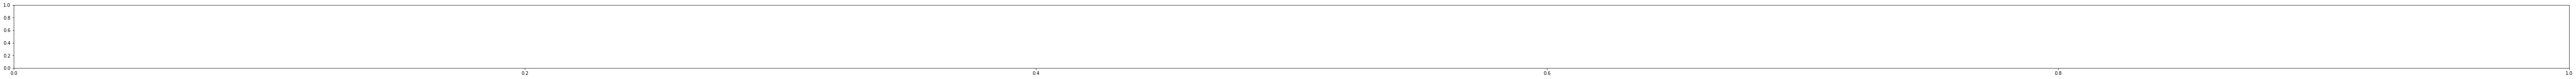

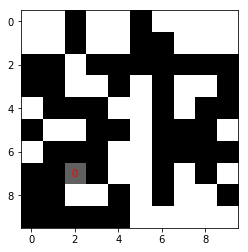

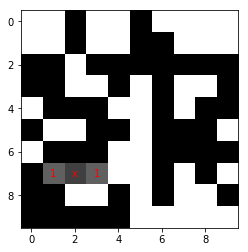

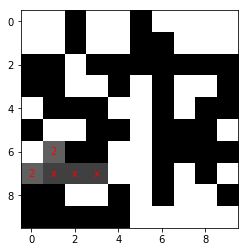

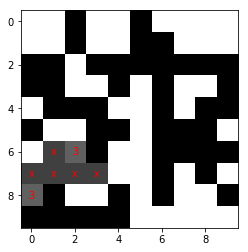

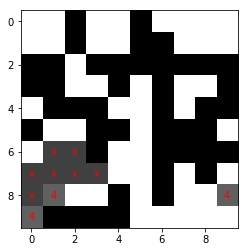

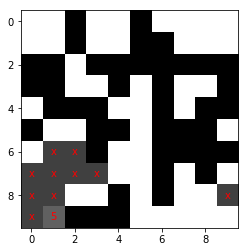

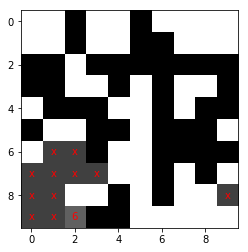

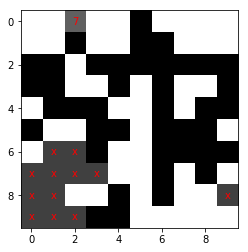

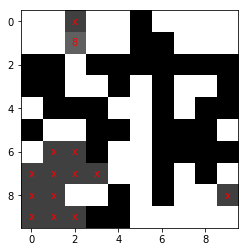

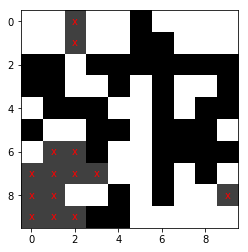

In [64]:
find_cluster_visualization(A, beta=.5, J=1.0, h=0.0)

## <span style="color:red">Exercise 2 (4 points) </span>

1. Implement the function `find_cluster` so that it produces equivalent results to those shown in the cells above. 2. Visualization of the intermediate steps during the computation of the cluster are optional.
3. The resulting function must return a boolean mask, `cluster`,of the same shape as the array of spins `spins`. Use dtype=bool for `cluster` numpy array.

The implemented function `find_cluster` can now be used to perform a MC simulation using the Wolff algorithm below.

In [67]:
def Wolff_Sim_2D_Ising(spins, J=1.0, h=0.0, beta=1.0, IT=100, plot=True):
    """
    Function that performs a MC simulation of the 1-D Ising system using the Wolff algorithm.
    
    Parameters
    ----------
    spins : 2-D array of spins to be used a initial condition.
    beta : Inverse of temperature 1/kT.
    J : Interaction strength.
    h : External field strength.
    IT : Number of steps/iterations of the Metropolis-Hastings algorithm.
    plot : Boolean flag to indicate whether plots of time series are generated (True) or not (False).
    
    Returns
    -------
    spins : Final configuration of spins by the end of the simulation.
    tseries : 2-D numpy array of shape (3,IT) containing simulation time tseries[0,:], energy per spin tseries[1,:]
              and magnetization per spin tseries[2,:].
    """
    
    N = spins.size # Number of spins in simulation
    tseries = zeros(shape=(3,IT), dtype=float)

    # Wolff algorithm
    for it in tqdm(range(IT), desc='Algorithm Iteration'):
        cluster = find_cluster(spins=spins,
                               beta=beta,
                               J=J,
                               h=h
                              )
        
        # simple_visualization(spins=spins, grid=False, annotate=False, mask=cluster, mask_value=str(it))
        
        spins[cluster] = -spins[cluster]
        
        # Time series
        tseries[1,it] = H_2DI(s=spins, J=J, h=h, PBC=True) # Energy
        tseries[2,it] = abs( spins.sum() ) # Magnetization
        
    E = tseries[1,:]/float(N) # Energy per spin
    M = tseries[2,:]/float(N) # Magnetization per spin
    tseries[0,:] = arange(0,IT, dtype=float)
    
    if plot:
        # Quick plot of internal energy vs. time    
        fig, axl = plt.subplots()

        color = 'tab:red'
        axl.set_xlabel(r'Time $t$ [MC steps per site]')
        axl.set_ylabel(r'$\mathcal{E}(t)$ [per site]', color=color)
        axl.plot(tseries[0,:], E, color=color)
        axl.tick_params(axis='y', labelcolor=color)

        axr = axl.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        axr.set_ylabel(r'$\mathcal{M}(t)$ [per site]', color=color)
        axr.plot(tseries[0,:], M, color=color)
        axr.tick_params(axis='y', labelcolor=color)

        #fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()
    
    return spins, tseries

Temperature: 2.40 | Beta: 0.42


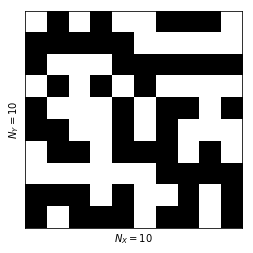

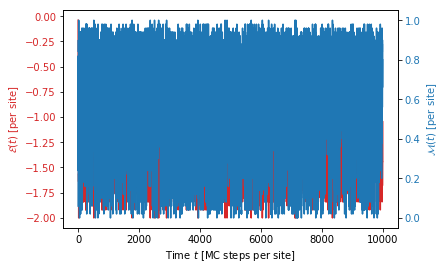

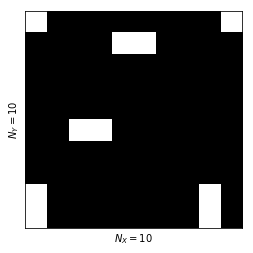

In [93]:
# Other params
J = 1.0
h = 0.0

# Temperature
kT = 2.4*J
beta = 1.0/kT

print('Temperature: %2.2f | Beta: %2.2f' % (kT, beta))

# Number of iterations
IT = 10000

foo = generate_spins(N=(10,10), dim=2, seed=2)

simple_visualization(spins=foo, grid=False, annotate=False)

si,tseries = Wolff_Sim_2D_Ising(spins=foo, 
                                J=J, 
                                h=h, 
                                beta=beta, 
                                IT=IT,
                                plot=True
                               )

simple_visualization(spins=si, grid=False, annotate=False)


Correlation time for time series:   1 | iteration:     9874
Correlation time for time series:   2 | iteration:        2


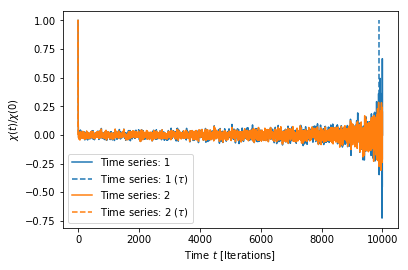

In [94]:
chi,taus = autocorrelationTime(tseries, semilog=False)

De aquí podemos notar que el tiempo de correlación es igual a dos iteraciones, por lo que siempre que tomemos mediciones cada 4 o más iteraciones, podemos decir que tales mediciones están poco correlacionadas

## <span style="color:red">Exercise 3 (3 points) </span>

In this exercise you will have to use the time series of the MC simulations using the Wolff algorithm for:

1. Compute the magnetization and specific heat per spin for a grid of $10\times 10$ spins using the Wolff algorithm.
2. Use the notes `Tony_Guttmann_Notes.pdf` in the Google Drive folder for computing the analytical magnetization and plot it agains the numerical results.
3. Compute the variations in both the magnetization and specific heat using the **bootstrap method** and plot them as error bars.

**NOTE 1**: in the case of the Wolff algorithm there is no concept of a number of iterations corresponding to a MC pass, since a single step of the Wolff algorithm correspond to a MC pass in the case of the Metropolis-Hastings method.

**NOTE 2**: A possible layout for your plots might be as the one shown below.

<img src="example.png">

In [98]:
# Other params
J = 1.0
h = 0.0

# Number of iterations
IT = 50000

kT = J*linspace(start=0.5, stop=5.0, num=50)
magnetization = zeros(shape=len(kT), dtype=float)
magnetization_error = zeros(shape=len(kT), dtype=float)
magnetization_analytic = zeros(shape=len(kT), dtype=float)

specific_heat = zeros(shape=len(kT), dtype=float)
specific_heat_error = zeros(shape=len(kT), dtype=float)

for jj,kT_ in tqdm(enumerate(kT), desc='SIMULATIONS'):
    beta_ = 1.0/kT_
    
    si,tseries = Wolff_Sim_2D_Ising(spins=generate_spins(N=(10,10), dim=2, seed=2), 
                                    J=J, 
                                    h=h, 
                                    beta=beta_, 
                                    IT=IT,
                                    plot=False
                                   )

    # Number of spins in simulation
    N = si.size

    # Offset in units of iterations
    offset = 20 #Para asegurarnos que sea varios tiempos de correlación 

    initial_index = offset
    
    # To implement
    # Sample size for bootstrap computation
    sample_size = int(IT/4) #Procurando que la distancia promedio entre medición sea dos tiempos de 
                            #correlación 
    # Number of samples for bootstrap computation
    num_samples = 40
    
    m = zeros(shape=num_samples, dtype=float)
    c = zeros(shape=num_samples, dtype=float)

    for ii in tqdm(range(num_samples), desc='Samples'):
        # We compute the initial and final indices for each block
        mask = random.randint(low=initial_index, high=tseries.shape[1], size=sample_size, dtype=int)
    
        # To implement
        m[ii] = (1/N)*sum(tseries[2,mask])/sample_size #Promedio de la magnetización por espín de la muestra tomada 
        c[ii] =(beta_**2/N)*(sum(tseries[1,mask]**2)/sample_size-(sum(tseries[1,mask])/sample_size)**2)
        #Promedio del calor específico por espín de la muestra tomada 
    # To implement
    m_av=sum(m)/num_samples #Calcula el promedio de la magnetización de cada muestra
    m2_av=sum(m**2)/num_samples #Calcula el promedio de la magnetiación al cuadrado de cada muestra
    magnetization[jj] = m_av
    magnetization_error[jj] =sqrt(m2_av-m_av**2) #Calcula la desviación estandar de la magnetización
    magnetization_analytic[jj] =0.0
    
    # To implement
    c_av=sum(c)/num_samples #Calcula el promedio del calor específico
    c2_av=sum(c**2)/num_samples #Calcula el promedio del cuadrado del calor específico
    specific_heat[jj] = c_av 
    specific_heat_error[jj] = sqrt(c2_av-c_av**2) #Calcula la desviación estandar del calor específico

En esta sección del códico se calcula la magnetización y el calor específico para una muestra de 5x5 átomos a diferentes temperaturas empleando el algoritmo de Wolf y el método de bootstrap.

El método de bootstrap consiste en generar listas de n mediociones de forma aleatoria de tal forma que preferentemente (aunque no afecta tanto al resultado final) tales medicines sean independientes de acuerdo al criterio de independencia que nos da el tiempo de correlación, es decir, procurando que la distancia entre mediciones sea mayor a dos veces el tiempo de correlación. 

Como el conjunto de mediciones se toma de forma aleatoria, procuramos que el tamaño de la muetra sea de 
$$\begin{equation}
n=\frac{t_{max}}{2 \tau}
\end{equation}$$
Ya que esto permite que la distancia promedio entre cada medición sea $2 \tau$. Sin embargo también se busca que el código no tome demasiado tiempo por lo que cualquier distanciamiento mayor que no nos de un número pobre de medidas por muestra es aceptable. 

Una vez obtenida la muestra, se calcula el promedio de la magnetización y el calor específico empleando las fórmulas usadas en el ejercicio 1. 

Se hace un "resampling" aleatorio un total de $N_{samples}$ y se calcula la magnetización y el calor específico en cada ocasión, lo cual nos perimte obtener sus errores.
$$
\sigma_m=\sqrt{\langle m^2\rangle-\langle m\rangle^2}
$$

$$
\sigma_c=\sqrt{\langle c^2\rangle-\langle c\rangle^2}
$$

In [99]:
def Analitic_Magnetization(kT,J):
    """ Esta función calcula la magnetización analítica encontrada en las notas
        vía los parámetros kT y J (la constante de acoplamiento)
    """
    s=sinh(2*J/kT)
    if 1-s**(-4)>0.: 
        M=(1-s**(-4))**(1/8)
    else:
        M=0
    return M 

In [100]:
magnetization_analytic=[]
for kT_ in kT:
    M=Analitic_Magnetization(kT_,J)
    magnetization_analytic.append(M)

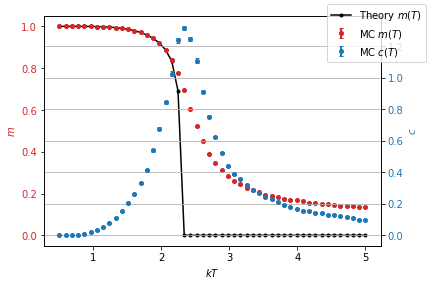

In [101]:
fig, axl = plt.subplots()

color = 'tab:red'
axl.set_xlabel(r'$kT$')
axl.set_ylabel(r'$m$', color=color)
axl.errorbar(kT, magnetization, magnetization_error, color=color, 
             marker='o', elinewidth=2.0, linewidth=0.0, markersize=4.0,
             capsize=2.0, label='MC $m(T)$')
axl.plot(kT, magnetization_analytic, color='black', marker='.', label='Theory $m(T)$')
axl.tick_params(axis='y', labelcolor=color)

axr = axl.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
axr.set_ylabel(r'$c$', color=color)
axr.errorbar(kT,specific_heat, specific_heat_error, color=color,
             elinewidth=2.0, linewidth=0.0, marker='o',markersize=4.0,
             capsize=2.0,label='MC $c(T)$')
axr.tick_params(axis='y', labelcolor=color)

plt.grid(b=True, which='both', axis='both')
fig.tight_layout()  # otherwise the right y-label is slightly clipped


fig.legend()
plt.show()